In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
import json
import glob
import itertools
import scipy as sp
import numpy as np
import pandas as pd
from collections import defaultdict

In [15]:
sample_data_dir = "../data/extracts/testv1/652/"
report_paths = glob.glob(sample_data_dir + '*')
sample_report = report_paths[0]

In [16]:
reports = []
for report_p in report_paths:
    with open(report_p, "r") as fobj:
        reports.append(json.load(fobj))

# Analysis Goals

- Visualize Waterbolt damage distribution
    - ... conditioned on mage average item level.

In [175]:
wb_dmg = [e["amount"] for e in itertools.chain.from_iterable(reports) if e["type"] == "damage"]

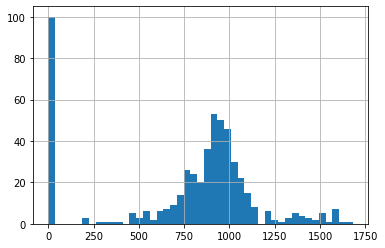

In [176]:
wbs = pd.Series(wb_dmg)
ax = wbs.hist(bins=45);

In [181]:
wbs = pd.DataFrame(wb_events)

In [186]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

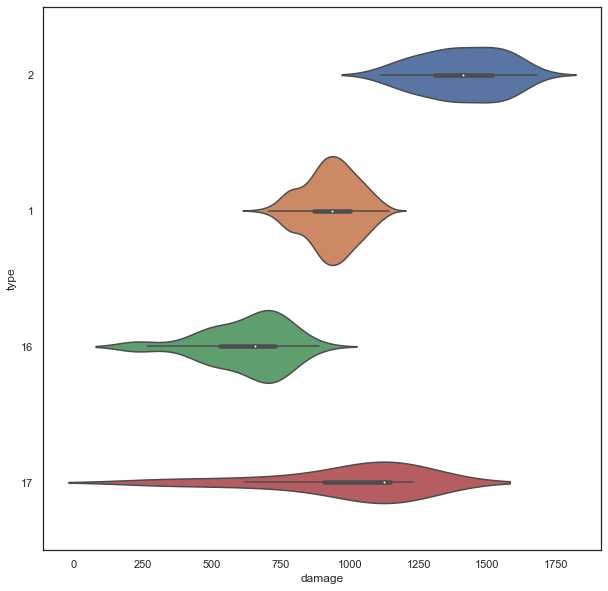

In [199]:
plt.figure(figsize=(10,10))
wbs["type"] = wbs["type"].map(lambda x: str(x))
sns.violinplot(data=wbs, x="damage", y="type");

The above with manual inspection, leads the the following observations:
- 1: Hit (No resist / mitigated)
- 2: Critical hit
- 14: Fully resisted
- 16: Hit + partially resisted & mitigated
- 17: Hit + partially resisted

In [77]:
(wbs == 0).sum() / wbs.count()

0.18867924528301888

Full resistance rate over the sample is about ~18%.

Let's look at conditioning on average item level.

In [180]:
ilvl_for_target = {}
wb_events = []

# Assuming that the events are correctly ordered ...
for report in reports:
    ilvl_for_target = {}
    src_to_target = {}
for e in get_events_iter():
    if e["type"] == "summon":
        src_to_target[e["sourceID"]] = e["targetID"]
    if e["type"] == "combatantinfo":
        gear_ilvls = []
        for i, g in enumerate(e["gear"]):
            # Ignore shirt
            if i == 3:
                continue
            gear_ilvls.append(g["itemLevel"])
        ilvl_for_target[src_to_target[e["sourceID"]]] = np.mean(gear_ilvls)
    elif e["type"] == "damage" and e["amount"] > 0:
        wb_events.append({"type": e["hitType"], "damage": e["amount"], "ilvl": ilvl_for_target[e["sourceID"]]})

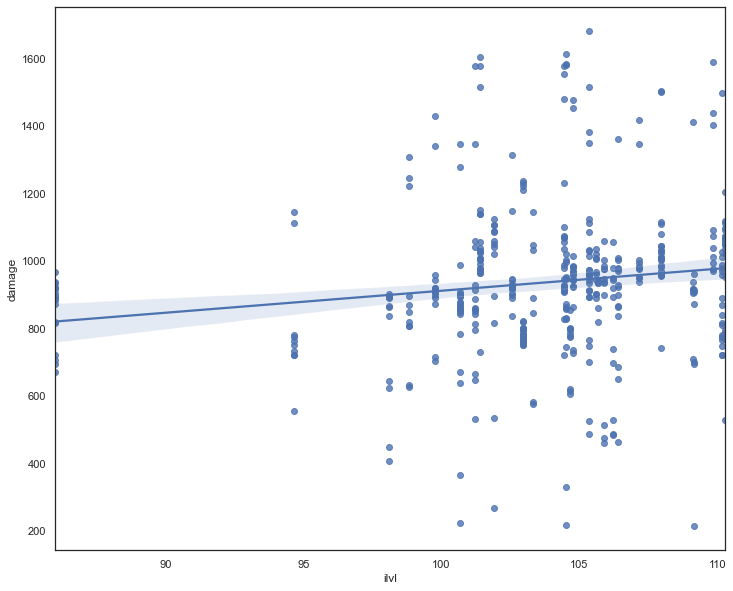

In [201]:
plt.figure(figsize=(12,10))
sns.regplot(data=wbs, x='ilvl', y='damage');

## Review

While there is a linear relationship, the damage variance seems too high at the minute for it to be particularly useful. Per the GH issue:

```
We're missing base and scaling data for mana/crit/hit.
```

For mana - unless a player is significantly undergeared / underbuffed it seems unlikely that a water elemental is going to OOM based on my own anecdotal experience. Still I should be able to calculate this offline.
For crit and hit we can try the following:

- Get hit/crit rating for mage.
- Look at linear relationship between mage's hit/crit and observed hit/crit rate.

## Action Items

### In-game
- Determine if there is any latency for waterbolt click / damage via looking combat logs.
- Calculate intellect scaling via clothing piece-wise sampling.

### Analysis
- Mage hit/crit to empirical waterbolt hit/crit stats.